In [1]:
from skimage import feature
import numpy as np
import matplotlib.pyplot as plt
import skimage.color as color
from skimage.draw import circle_perimeter
from skimage import img_as_float
from sklearn.cluster import MeanShift
from scipy.ndimage.filters import convolve
from skimage import measure

In [2]:
def binReduction(im, votes, radius):
    w, h = np.shape(votes)

    out = np.zeros(shape=(w,h))

    for i in range(0, w, 10):
        for j in range(0, h, 10):
            try:
                subMatrix = votes[i-5:i+5, j-5:j+5]
                out[i,j] = np.sum(subMatrix)
            except:
                pass
    plt.title('Bin Reduction')
    plt.imshow(out)
    plt.show()

    # FIND AND DRAW CIRCLES
    centers = list()
    for i in range(w):
        for j in range(h):
            if out[i, j] >= 50:
                    centers.append((j, i))


    drawCircles(im, centers, radius)

In [3]:
def detectCircles(im, radius, useGradient=False, sigma= 1,threshold=0.8, epsilon='auto', bin_scale=1, hough_output=False):
    img_gray = img_as_float(color.rgb2gray(im))
    w, h = np.shape(img)

    edges = feature.canny(img, sigma=sig)
    if useGradient:
        eps = 1e-10
        g_x = convolve(img_gray, np.array([[1,-1]]), mode='wrap')
        g_y = convolve(img_gray, np.array([[1],[-1]]), mode="wrap")
        g_x[g_x == 0] = eps
        g_direct = np.arctan(g_y / g_x)
    
    ds = np.gradient(img)
    gradients = np.arctan2(-ds[1], ds[0])

    votes = np.zeros(shape=(w, h))
    for i in range(w):
        for j in range(h):
            if edges[i, j]:
                if useGradient:
                    theta = gradients[i, j]
                    theta2 = theta + np.pi
                    a = i - radius * np.cos(-theta)
                    b = j - radius * np.sin(-theta)
                    aInv = i - radius * np.cos(theta2)
                    bInv = j - radius * np.sin(theta2)
                    try:
                        votes[int(a), int(b)] += 1
                        votes[int(aInv), int(bInv)] += 1

                    except:
                        pass

                else:
                    for theta in np.radians(range(360)):
                        a = i - radius * np.cos(theta)
                        b = j - radius * np.sin(theta)
                        try:
                            votes[int(a), int(b)] += 1
                        except:
                            pass


    binReduction(im, votes, radius)

    plt.title("Accumulator Array")
    plt.imshow(votes)
    plt.show()

    # find centers
    centers = list()
    for i in range(w):
        for j in range(h):
            if useGradient:
                if votes[i, j] >= 7:
                    centers.append((j, i))
            else:
                if votes[i, j] >= 200:
                    centers.append((j, i))

    if not centers:
        ind = np.unravel_index(votes.argmax(), votes.shape)
        print(ind)
        centers.append((ind[1], ind[0]))
    drawCircles(im, centers, radius)
    return centers

In [4]:
def drawCircles(im, centers, r):
    img = np.copy(im)
    for c in centers:
        for theta in np.radians(range(360)):
            a = c[0] - r * np.cos(theta)
            b = c[1] - r * np.sin(theta)
            try:
                img[int(b), int(a)] = [255, 0, 0]
            except:
                pass

    plt.title("Output: r=" + str(r))
    plt.imshow(img)
    plt.show()

In [4]:
#export
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread,imsave
from skimage.feature import canny
from skimage.color import rgb2gray
from skimage.draw import circle_perimeter
from skimage import img_as_float
from scipy.ndimage.filters import convolve
from skimage import measure

In [5]:
#export
def detect_circles(img, radius, use_Grad=False, sigma=1.0, threshold=0.8, epsilon='auto', bin_scale=1, hough=False):
    
    # Detect edges 
    img_gray = img_as_float(rgb2gray(img))
    edges = canny(img_gray, sigma=sigma)
    
    #For examples using gradient
    if use_Grad:
        g_x = convolve(img_gray, np.array([[1,-1]]), mode='wrap')
        g_y = convolve(img_gray, np.array([[1],[-1]]), mode="wrap")
        g_x[g_x == 0] = 1e-10
        g_direct = np.arctan(g_y / g_x)
    
    # Detect circles 
    flag = False
    if type(radius) is not list:
        flag = True
        radius = [radius, radius + 1]
    temp_0 = radius[1] - radius[0]
    temp_1 = int(img.shape[0] * bin_scale)
    temp_2 = int(img.shape[1] * bin_scale)
    votes = np.zeros((temp_0, temp_1, temp_2))
    for rad in range(radius[0], radius[1]):
        hough_space = np.zeros((temp_1, temp_2))
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                if edges[row, col] != 0:
                    if not use_Grad and epsilon == 'auto':
                        v = np.linspace(0, 2 * np.pi, 6 * rad)
                    elif not use_Grad and epsilon!= 'auto':
                        v = np.arange(0, 2 * np.pi, epsilon)
                    if use_Grad:
                        theta = g_direct[row, col]
                        v = np.array([theta, theta-np.pi])
                    for theta in v:
                        vote_x = int(round(col + rad * np.cos(theta)) * bin_scale)
                        vote_y = int(round(row + rad * np.sin(theta)) * bin_scale)
                        if vote_x >= 0 and vote_x < hough_space.shape[1] and vote_y >= 0 and vote_y < hough_space.shape[0]:
                            hough_space[vote_y, vote_x] = hough_space[vote_y, vote_x] + 1
        votes[rad - radius[0]] = hough_space

        
    
    if flag:
        hough_space = votes[0]
        centers = (np.transpose(np.array(np.where(hough_space >= hough_space.max() * threshold))) / bin_scale).astype(int)
        if not hough:
            return centers
        return centers, hough_space
    else:
        centroid = (np.transpose(np.array(np.where(votes >= votes.max() * threshold))) / bin_scale).astype(int)
        centroid[:, 0] = centroid[:, 0] + radius[0]
        if not hough:
            return centroid
        return centroid, votes

In [6]:
#export
def extraCredit():
    egg_img = np.array(imread('./egg.jpg'))
    jupiter_img = np.array(imread('./jupiter.jpg'))
    draw_color = np.array([255, 255, 0])
    
    radius = [2,12]
    sigma = 2
    threshold = 0.65
    use_gradient = False
    bin_scale = 1
    epsilon = 0.05

    centers, hough_space = detect_circles(egg_img, radius, use_Grad=use_gradient, threshold=threshold, sigma=sigma, bin_scale=bin_scale, epsilon=epsilon, hough=True)

    hough_img = hough_space.astype(int).sum(axis=0)
    scale_factor = 255 / hough_img.max()
    hough_img = (scale_factor * hough_img).astype(np.uint8)
    circled_img = egg_img.copy()
    for center in centers:
        circle = circle_perimeter(center[1], center[2], radius=center[0], shape=img.shape)
        circled_img[circle] = draw_color
    imsave(save_name_circled, circled_img)

    plt.rcParams['figure.figsize'] = [16, 10]
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(circled_img)
    axs[1].imshow(hough_img, cmap='gray')
    axs[0].title.set_text('Circles Marked')
    axs[1].title.set_text('Accumulator Array')
    plt.show()
    
    hough_img = hough_space
    hough_img_threshold = hough_img.copy()
    hough_img_threshold[hough_img < hough_img.max() * threshold] = 0
    hough_img_threshold[hough_img_threshold > 0] = 1
    hough_img_threshold = hough_img_threshold.astype(bool)

    labels = measure.label(hough_img_threshold, background=0)
    count = labels.max()
    centers = []
    for i in range(1, count + 1):
        centers.append((np.mean(np.array(np.where(labels == i)), axis=1) / bin_scale).astype(int))
    centers = np.array(centers)

    circled_img = egg_img.copy()
    for center in centers:
        circle = circle_perimeter(center[1], center[2], radius=center[0] + radius[0], shape=img.shape)
        circled_img[circle] = draw_color

    print('Circle Count:', count)

In [7]:
#export
if __name__ == '__main__':
    egg_img = np.array(imread('./egg.jpg'))
    jupiter_img = np.array(imread('./jupiter.jpg'))
    draw_color = np.array([255, 255, 0]) #yellow for circles 
    
    
    if type(radius) is list:
        hough_img = hough_space.astype(int).sum(axis=0)
        scale_factor = 255 / hough_img.max()
        hough_img = (scale_factor * hough_img).astype(np.uint8)
    else:
        scale_factor = 255 / hough_space.max()
        hough_img = (scale_factor * hough_space).astype(np.uint8)
    # test 1
    img_name = 'jupiter'
    radius = 110
    sigma = 6
    threshold = 0.99
    use_Grad = False
    bin_scale = 1
    epsilon = 0.1
    centers, votes = detect_circles(img, radius, use_Grad=use_Grad, threshold=threshold, sigma=sigma, bin_scale=bin_scale, epsilon=epsilon, hough=True)
    scale_factor = 255 / hough_space.max()
    hough_img = (scale_factor * hough_space).astype(np.uint8)
    for center in centers:
        circle = circle_perimeter(center[0], center[1], radius=radius, shape=img.shape)
        circled_img[circle] = draw_color
    plt.rcParams['figure.figsize'] = [16, 10]
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(circled_img)
    axs[1].imshow(hough_img, cmap='gray')
    axs[0].title.set_text('Circles Marked')
    axs[1].title.set_text('Accumulator Array')
    plt.show()

NameError: name 'radius' is not defined

option 0 - 6:4


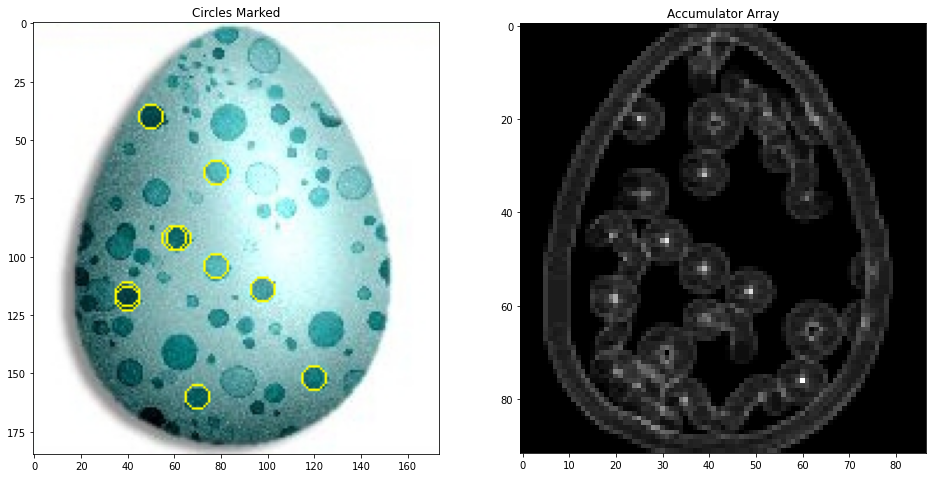

Circle Count: 8


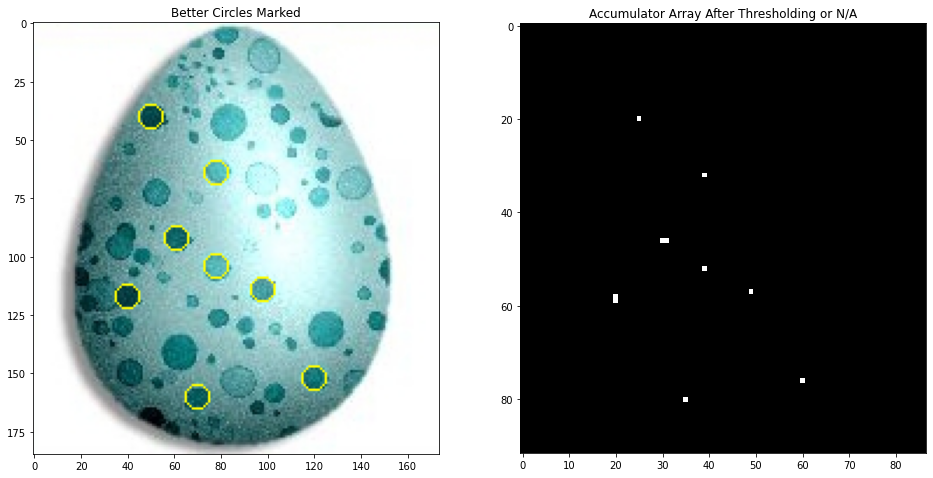

In [8]:
#export
if __name__ == '__main__':
    param_lists = [
        ['jupiter', 110, 6, 0.99, False, 1, .1],
        ['jupiter', 110, 6, 0.80, True, 1, .1],
        ['egg', 5, 3, 0.60, False, 1, 'auto'],           # use this for count
        ['egg', 5, 3, 0.70, True, 1, 'auto'],
        ['egg', 5, 3, 0.60, False, 0.5, 'auto'],
        ['egg', [2, 12], 2, 0.65, False, 1, .05],
        ['jupiter', [3, 110], 6, 0.80, True, 1.0, 0.1]
    ]
    
    egg_img = np.array(imread('./egg.jpg'))
    jupiter_img = np.array(imread('./jupiter.jpg'))

    # toggle for differnet image parameters
    param_i = int(input('option 0 - {}:'.format(len(param_lists) - 1)))

    img_name = param_lists[param_i][0]
    radius = param_lists[param_i][1]
    sigma = param_lists[param_i][2]
    threshold = param_lists[param_i][3]
    use_gradient = param_lists[param_i][4]
    bin_scale = param_lists[param_i][5]
    epsilon = param_lists[param_i][6]

    # image file name
    save_name_circled = '{}_circled{}_grad{}{}.jpg'.format(
        img_name,
        '_no' if not use_gradient else '',
        '_scale' if bin_scale != 1 else '',
        '_rad' if type(radius) is list else '' )
    save_name_hough = '{}_hough{}_grad{}.jpg'.format(
        img_name,
        '_no' if not use_gradient else '',
        '_scale' if bin_scale != 1 else '')
    if img_name == 'egg':
        img = egg_img.copy()
    elif img_name == 'jupiter':
        img = jupiter_img.copy()

    # marker color
    draw_color = np.array([255, 255, 0])

    centers, hough_space = detect_circles(img, radius, use_Grad=use_gradient, threshold=threshold, sigma=sigma, bin_scale=bin_scale, epsilon=epsilon, hough=True)
    if type(radius) is list:
        hough_img = hough_space.astype(int).sum(axis=0)
        scale_factor = 255 / hough_img.max()
        hough_img = (scale_factor * hough_img).astype(np.uint8)
    else:
        scale_factor = 255 / hough_space.max()
        hough_img = (scale_factor * hough_space).astype(np.uint8)

    circled_img = img.copy()
    for center in centers:
        if type(radius) is not list:
            circle = circle_perimeter(center[0], center[1], radius=radius, shape=img.shape)
        else:
            circle = circle_perimeter(center[1], center[2], radius=center[0], shape=img.shape)
        circled_img[circle] = draw_color
    imsave(save_name_circled, circled_img)
    if type(radius) is not list:
        imsave(save_name_hough, hough_img)

    plt.rcParams['figure.figsize'] = [16, 10]
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(circled_img)
    axs[1].imshow(hough_img, cmap='gray')
    axs[0].title.set_text('Circles Marked')
    axs[1].title.set_text('Accumulator Array')
    plt.show()
    
    if type(radius) is list:
        hough_img = hough_space
    hough_img_threshold = hough_img.copy()
    hough_img_threshold[hough_img < hough_img.max() * threshold] = 0
    hough_img_threshold[hough_img_threshold > 0] = 1
    hough_img_threshold = hough_img_threshold.astype(bool)

    labels = measure.label(hough_img_threshold, background=0)
    count = labels.max()
    # print(labels.shape)
    centers = []
    for i in range(1, count + 1):
        centers.append((np.mean(np.array(np.where(labels == i)), axis=1) / bin_scale).astype(int))
    centers = np.array(centers)

    circled_img = img.copy()
    for center in centers:
        # print(center)
        if type(radius) is list:
            circle = circle_perimeter(center[1], center[2], radius=center[0] + radius[0], shape=img.shape)
        else:
            circle = circle_perimeter(center[0], center[1], radius=radius, shape=img.shape)
        circled_img[circle] = draw_color
    imsave('reduced_' + save_name_circled, circled_img)

    print('Circle Count:', count)
    plt.rcParams['figure.figsize'] = [16, 10]
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(circled_img)
    if type(radius) is not list:
        axs[1].imshow(hough_img_threshold, cmap='gray')
    else:
        axs[1].imshow(circled_img)
    axs[0].title.set_text('Better Circles Marked')
    axs[1].title.set_text('Accumulator Array After Thresholding or N/A')
    plt.show()
    